In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam, Adagrad
from renom.cuda import set_cuda_active
# if you would like to use GPU, set True, otherwise you should be set to False
set_cuda_active(False)

import sys
import os
import talib
sys.path.append('/Users/toshio/project/fx')
from config import token
from lib.preprocess import Preprocess

import oandapy

In [2]:
gran = 'H1'
look_back = 10
pred_length = 1

In [3]:
with open('../model/std_scaler_{}.pickle'.format(gran), mode='rb') as f:
    stds = pickle.load(f)
with open('../model/mean_scaler_{}.pickle'.format(gran), mode='rb') as f:
    means = pickle.load(f)

In [4]:
sequential = rm.Sequential([
    rm.Lstm(30),
    rm.Lstm(10),
    rm.Dense(pred_length)
])
sequential.load("../model/lstm_{}_{}.h5".format(gran, look_back))

In [5]:
oanda = oandapy.API(environment="practice", access_token=token)

In [9]:
res = oanda.get_history(instrument="USD_JPY", granularity=gran, count = 500)

In [14]:
prep = Preprocess(res)
df = prep.prep_data()

In [15]:
df_std = df.copy()
stds, means = [], []
for col in df:
    std = df[col].std()
    mean = df[col].mean()
    df_std[col] = (df[col] - mean) / std
    stds.append(std)
    means.append(mean)
data = np.array(df_std)

In [17]:
def create_dataset(data, look_back, pred_length):
    exp, target = [], []
    for i in range(len(data) - look_back - pred_length):
        exp.append(data[i : i+look_back, :])
        target.append(data[i + look_back : i + look_back + pred_length, 9].T[0])
        
    n_features = np.array(exp).shape[2]
    exp = np.reshape(np.array(exp), [-1, look_back, n_features])
    target = np.reshape(np.array(target), [-1, 1])
    return exp, target

In [21]:
X, y = create_dataset(data, look_back, pred_length)
T = X.shape[1]

In [23]:
for t in range(T):
    y_pred = sequential(X[:, t, :])
sequential.truncate()

In [27]:
prediction = y_pred * stds[9] + means[9]

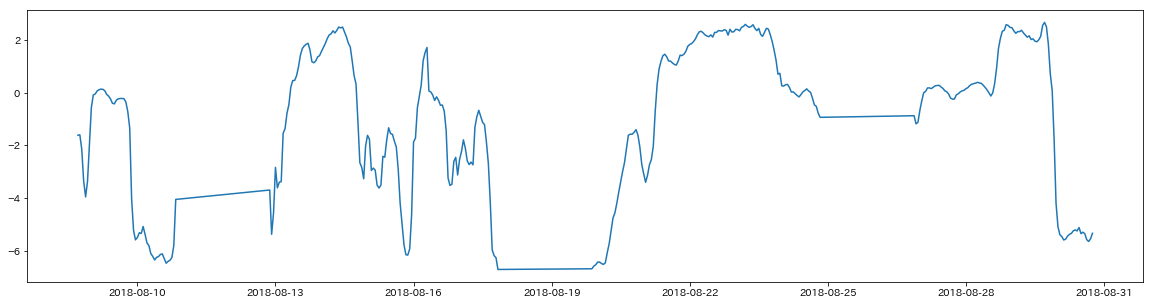

In [44]:
plt.figure(figsize = (20,5))
plt.plot(df[11:].index, y_pred)
plt.show()

In [42]:
df

closeAsk  closeBid  highAsk  highBid   lowAsk   lowBid  \
time                                                                          
2018-08-08 06:00:00   111.112   111.101  111.282  111.269  111.112  111.100   
2018-08-08 07:00:00   110.955   110.942  111.126  111.112  110.845  110.827   
2018-08-08 08:00:00   110.968   110.955  111.002  110.990  110.925  110.913   
2018-08-08 09:00:00   110.935   110.922  110.992  110.979  110.898  110.884   
2018-08-08 10:00:00   111.053   111.040  111.056  111.042  110.917  110.905   
2018-08-08 11:00:00   111.134   111.121  111.148  111.136  111.032  111.018   
2018-08-08 12:00:00   111.134   111.121  111.200  111.185  111.047  111.033   
2018-08-08 13:00:00   110.982   110.969  111.151  111.136  110.961  110.948   
2018-08-08 14:00:00   110.968   110.951  111.050  111.037  110.944  110.931   
2018-08-08 15:00:00   110.960   110.946  111.001  110.986  110.917  110.904   
2018-08-08 16:00:00   110.976   110.961  110.998  110.986  110.916  110.902   
2018-08-08 17:00:00   110.918   110.904  110.994  110.980  110.918  110.904   
2018-08-08 18:00:00   110.978   110.964  111.002  110.987  110.905  110.891   
2018-08-08 19:00:00   111.002   110.988  111.010  110.997  110.978  110.965   
2018-08-08 20:00:00   110.960   110.944  111.000  110.985  110.930  110.914   
2018-08-08 21:00:00   110.941   110.910  111.060  110.987  110.928  110.902   
2018-08-08 22:00:00   110.893   110.876  110.955  110.936  110.876  110.860   
2018-08-08 23:00:00   110.920   110.904  110.941  110.927  110.874  110.860   
2018-08-09 00:00:00   110.828   110.814  110.918  110.902  110.785  110.771   
2018-08-09 01:00:00   110.827   110.814  110.862  110.849  110.763  110.749   
2018-08-09 02:00:00   110.792   110.778  110.830  110.816  110.716  110.703   
2018-08-09 03:00:00   110.812   110.798  110.859  110.846  110.788  110.775   
2018-08-09 04:00:00   110.931   110.916  110.943  110.928  110.756  110.742   
2018-08-09 05:00:00   110.960   110.947  111.058  111.039  110.924  110.908   
2018-08-09 06:00:00   111.039   111.023  111.089  111.074  110.952  110.938   
2018-08-09 07:00:00   111.051   111.037  111.085  111.072  110.974  110.960   
2018-08-09 08:00:00   111.135   111.122  111.180  111.165  111.028  111.012   
2018-08-09 09:00:00   111.149   111.136  111.161  111.149  111.106  111.093   
2018-08-09 10:00:00   111.126   111.112  111.192  111.179  111.109  111.095   
2018-08-09 11:00:00   111.142   111.129  111.150  111.136  111.107  111.094   
...                       ...       ...      ...      ...      ...      ...   
2018-08-29 13:00:00   111.453   111.434  111.507  111.492  111.335  111.320   
2018-08-29 14:00:00   111.672   111.659  111.720  111.706  111.434  111.420   
2018-08-29 15:00:00   111.799   111.785  111.836  111.823  111.664  111.651   
2018-08-29 16:00:00   111.749   111.736  111.811  111.798  111.738  111.725   
2018-08-29 17:00:00   111.653   111.640  111.774  111.760  111.630  111.617   
2018-08-29 18:00:00   111.696   111.683  111.709  111.695  111.644  111.630   
2018-08-29 19:00:00   111.707   111.693  111.726  111.714  111.679  111.664   
2018-08-29 20:00:00   111.691   111.670  111.726  111.709  111.673  111.655   
2018-08-29 21:00:00   111.744   111.726  111.756  111.733  111.660  111.610   
2018-08-29 22:00:00   111.732   111.718  111.763  111.749  111.704  111.688   
2018-08-29 23:00:00   111.692   111.678  111.745  111.730  111.669  111.655   
2018-08-30 00:00:00   111.714   111.701  111.760  111.747  111.678  111.663   
2018-08-30 01:00:00   111.602   111.588  111.745  111.731  111.524  111.510   
2018-08-30 02:00:00   111.633   111.620  111.665  111.651  111.589  111.576   
2018-08-30 03:00:00   111.620   111.607  111.671  111.658  111.609  111.596   
2018-08-30 04:00:00   111.663   111.652  111.674  111.662  111.622  111.610   
2018-08-30 05:00:00   111.658   111.646  111.685  111.671  111.636  111.623   
2018-08-30 06:00:00   111.694   111.679  111.724  111.711  111.651  111